## Libraries

In [60]:
import pandas as pd
from linearmodels import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log
from linearmodels.panel.data import PanelData

## Data

In [29]:
file_path = 'resources\Desktoppanel.csv'
data = pd.read_csv(file_path)

In [52]:
data.head()

smp  wave1  wave2  wave3  wave4  wave5  wave6  wave7  wave8  \
id    year                                                                
30001 2005    1      1      1      1      0      0      0      0      0   
      2007    1      1      1      1      0      0      0      0      0   
      2009    1      1      1      1      0      0      0      0      0   
30002 2005    1      1      1      1      1      0      0      0      0   
      2007    1      1      1      1      1      0      0      0      0   

            wave9  ...  ict034  ict035  ict036  ict037  ict038  ict039 ict040  \
id    year         ...                                                          
30001 2005      0  ...     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
      2007      0  ...     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
      2009      0  ...     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
30002 2005      0  ...     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
      2007      0  ...     NaN     NaN     NaN     NaN     NaN     NaN    NaN   

            ict041  1인당_노동생산성_변화량         y  
id    year                                   
30001 2005     NaN      -0.012966 -0.012966  
      2007     NaN       1.434783  1.434783  
      2009     NaN       2.287273  2.287273  
30002 2005     NaN      -0.014740 -0.014740  
      2007     NaN       2.609028  2.609028  

[5 rows x 3609 columns]

## Data Preprocessing

In [75]:
na_replacement = -9999

회사법인_구분 = 'aq2002'
상장여부 = 'aq2003'
전문경영인_유무 = 'aq2004'
경영형태 = 'aq2901'


주식회사 = 1
유한회사 = 2
합자회사 = 3
합명회사 = 4


예 = 1
아니오 = 2


소유경영체제 = 1
소유주_중심의_경영체제 = 2
주요_경영문제_결정권을_소유주가_가진_경영체제 = 3
전문경영체제 = 4
해당없음 = 97


미상장 = 4


기업체_변화 = ['aq2012r4', 'aq2012r5', 'aq2012r6', 'aq2012r7', 'aq2012r8', 'aq2012r11', 'aq2012r13', 'aq2012r14']


경영_형태 = 'aq2901'
사업체_업력 = 'w_age'
주력_제품의_국내_시장_경쟁_정도 = 'aq3008'
사업장_혁신_유형 = 'aq3901'
능력_근무성적_태도_등에_대해_평가_실시함 = 'cq1001'
성과배분제도_운영_여부 = 'cq3001'
우리사주제도_실시_여부 = 'cq3008'
지난_2년_동안_직무분석_실시한_적_있음 = 'dq1007b'
사무직_근로자의_초과근로가_정기적으로_이루어지는_정도 = 'dq3023'
선택적_근무시간제를_운영함 = 'dq3025'
탄력적_근로시간제를_운영함 = 'dq3027'
작년말_기준_노동조합이_있음 = 'mq1001'
작년_말_기준_노사협의회가_있음 = 'nq1004'


당기_매출액 = 'fpq2001'
전체_근로자_수 = 'epq3008'
주_근로시간_1인당_2013까지 = 'dq3919' 
주_초과_근로시간_1인당_2013까지 = 'dq3920' 
주_근로시간_1인당_2015이후 = 'per_week' 
주_근로시간_1인당 = 주_근로시간_1인당_2015이후


def determine_management_system(row):
    if row[전문경영인_유무] == 예:
        return 전문경영체제
    elif row[상장여부] < 미상장:
        return 소유주_중심의_경영체제
    elif row[회사법인_구분] == 합자회사:
        return 주요_경영문제_결정권을_소유주가_가진_경영체제
    else:
        return 소유경영체제
    

# X
Independent_var_keys = [
    경영_형태, 사업체_업력, *기업체_변화, 주력_제품의_국내_시장_경쟁_정도, 사업장_혁신_유형, 능력_근무성적_태도_등에_대해_평가_실시함,
    성과배분제도_운영_여부, 우리사주제도_실시_여부, 지난_2년_동안_직무분석_실시한_적_있음, 사무직_근로자의_초과근로가_정기적으로_이루어지는_정도,
    선택적_근무시간제를_운영함, 탄력적_근로시간제를_운영함, 작년말_기준_노동조합이_있음, 작년_말_기준_노사협의회가_있음
]

# y
개인당_노동생산성_변화량 = 'y' 
    
    
data[주_근로시간_1인당] = data[주_근로시간_1인당_2015이후].combine_first(
    data[주_근로시간_1인당_2013까지] + data[주_초과_근로시간_1인당_2013까지]
).fillna(na_replacement)

data[개인당_노동생산성_변화량] = data[당기_매출액] / (data[전체_근로자_수] * data[주_근로시간_1인당])
data[개인당_노동생산성_변화량] = log(data[개인당_노동생산성_변화량].where(data[개인당_노동생산성_변화량] > 0, 1e-10))
fixed_management_data = data[[전문경영인_유무, 상장여부, 회사법인_구분]].apply(determine_management_system, axis=1).fillna(해당없음)
data[경영_형태] = data[경영형태].combine_first(fixed_management_data)

pre_X = data[[*Independent_var_keys]]
data[[*Independent_var_keys]] = pre_X.fillna(na_replacement)

# data[]

## Estimation Structure

$$
\ln{Y_{iprt}} = \beta (Treat_i \times Post_t) + X_{iprt}\gamma + Fixed + \varepsilon_{iprt}
$$

### Controlled Vars

|             통제변수              |              코드              |                             비고                             |
|:-----------------------------:|:----------------------------:|:----------------------------------------------------------:|
|            재택근무 비율            |  'epq2007', 'epq9904' or ''  |         (전체 - 재택 수) / 전체 [~2013] or 시행 여부 [2015~]          |
|          최저임금 근로자 비율          |                              |                                                            |
|            기업 순이익             |                              |                                                            |
|         추가 근로제도 시행 여부         |                              |                                                            |
|             경영 형태             |           'aq2901'           | 회사법인_구분 = 'aq2002', 상장여부, 'aq2003', 전문경영인_유무 'aq2004'로 전처리 |
|            사업체 업력             |           'w_age'            |                                                            |
|            기업체 변화             | 'aq2012r4~r8, r11, r13, r14' |                                                            |
|      주력 제품의 국내 시장 경쟁 정도       |           'aq3008'           |                                                            |
|           사업장 혁신 유형           |           'aq3901'           |                                                            |
|   능력, 근무성적, 태도 등에 대해 평가 실시함   |           'cq1001'           |                                                            |
|         성과배분제도 운영 여부          |           'cq3001'           |                                                            |
|         우리사주제도 실시 여부          |           'cq3008'           |                                                            |
|    지난 2년 동안 직무분석 실시한 적 있음     |          'dq1007b'           |                                                            |
| 사무직 근로자의 초과근로가 정기적으로 이루어지는 정도 |           'dq3023'           |                      na at 2005, 2007                      |
|        선택적 근무시간제를 운영함         |           'dq3025'           |                                                            |
|        탄력적 근로시간제를 운영함         |           'dq3027'           |                                                            |
|        작년말 기준 노동조합이 있음        |           'mq1001'           |                                                            |
|       작년 말 기준 노사협의회가 있음       |           'nq1004'           |                    mq1001 + nq1004 가능할듯                    | 

### Fixed vars
 
|    고정효과    |
|:----------:|
|     지역     |
|     연도     |
|    산업분류    |
|     규모     |
| 산업규모 * 연도  |
|   연도별 기업   |
|   연도별 지역   |

## Regression

In [76]:

# data['Treat'] = 
# data['Post'] = 
# data['Treat x Post'] = data['Treat'] * data['Post'] 
panel = PanelData(data)
# data = data.set_index(['id', 'year'])

y = panel.dataframe[개인당_노동생산성_변화량]
X = panel.dataframe[[*Independent_var_keys]]

X = sm.add_constant(X)

model = PanelOLS(y, X, entity_effects=True, time_effects=True)

result = model.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

result

Dep. Variable:,y,R-squared:,0.0157
Estimator:,PanelOLS,R-squared (Between):,-8.323e+04
No. Observations:,20592,R-squared (Within):,-1.237e+05
Date:,"Wed, Jun 05 2024",R-squared (Overall):,-8.022e+04
Time:,18:14:43,Log-likelihood,-6.871e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,11.820
Entities:,4985,P-value,0.0000
Avg Obs:,4.1308,Distribution:,"F(21,15578)"
Min Obs:,1.0000,,
Max Obs:,9.0000,F-statistic (robust):,11.657


## Visualization

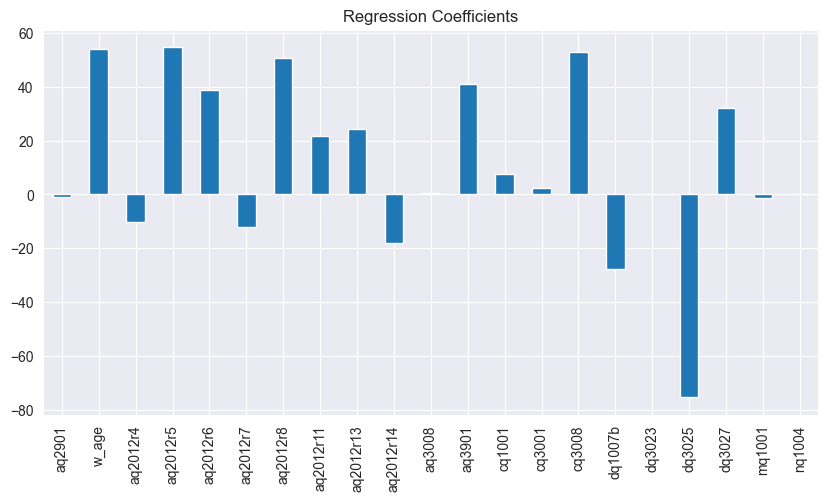

In [80]:
coefficients = result.params.drop('const') * 100

plt.figure(figsize=(10, 5))
coefficients.plot(kind='bar')
plt.title('Regression Coefficients')
plt.grid(True)
plt.show()